In [79]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

# Reading The Datasets
1. Session Dataset

In [80]:
sessionData = pd.read_csv('../input/session_related.csv')
sessionData.head()

,OrderId,IP_start_session,IP_end_session,Session_Pincode,Delivery_Pincode,IsValidGeo
0,86611,57.79.00.250,211.75.38.8,431401,431401,NO
1,61343,2.8.4.8,8.9.103.186,403712,403712,NO
2,55944,5.151.253.234,5.151.253.234,793101,793101,YES
3,842,235.231.255.2,235.231.255.2,177001,176992,NO
4,50594,255.251.119.201,255.251.119.201,799201,799201,NO


2. Outliers Dataset

In [81]:
genericData = pd.read_csv('../input/generic_outliers_data.csv')
genericData.head()

,CustId,Age,EmailId,MobileNo,MacAddress,AvgPurchase,City,OccupationalLevel,IncomeLevel,Pincode
0,100,18,WCkD3InDq@gmail.com,4916661116,A7-17-AC-BB-87-09,3580,Baidyanadh Deoghar,Technical,very low,814112
1,101,18,iPjORQGqy@hotmail.com,8156912083,3D-E0-06-66-01-00,7585,Chakpirang,Non-technical,very low,795102
2,102,18,ShyCmCDbmB@aol.com,6663941231,3A-DE-69-A8-98-04,4456,Kala pahad,Non-technical,very low,795122
3,103,18,VdjRDafd@yahoo.com,3761853308,15-74-5C-91-78-E6,91474,Ukhrul,Technical,very high,795142
4,104,18,rLaKt3AxMK@gmail.com,7391938452,BA-6B-47-85-66-E7,62522,Kulittalai,Non-technical,high,639104


3. Delivery Dataset

In [82]:
deliveryData = pd.read_csv('../input/delivery_related.csv')
deliveryData.head()

,CustId,OrderId,ProductId,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,OrderDate,AddressChangeDate,DeliveryDate,ReplacementDate,IsProductConsumable,IsOneTimeUseProduct,IsOfferCodeApplied,Fraud
0,47019,41601,41601,yes,no,yes,yes,2711,2711,25/01/2019,20/11/2018,28/01/2019,01/02/2019,yes,no,no,normal
1,20242,30352,30352,no,yes,no,no,2713,2710,06/02/2019,03/02/2019,10/02/2019,17/02/2019,yes,yes,no,normal
2,79619,12328,12328,yes,no,yes,yes,4146,4142,12/01/2019,30/07/2018,22/01/2019,01/02/2019,yes,no,yes,suspicious
3,80669,19203,19203,yes,no,yes,no,2709,2707,27/03/2019,14/06/2018,03/04/2019,06/04/2019,yes,no,yes,normal
4,64577,19842,19842,no,no,no,yes,8815,8811,17/01/2019,26/11/2018,21/01/2019,28/01/2019,yes,no,yes,normal


# Feature Engineering
#### Merging of Datasets and Extraction of required features from the given datasets

In [83]:
firstmerge = pd.merge(deliveryData,sessionData,on='OrderId')

In [84]:
MergedDataset = pd.merge(firstmerge,genericData,on='CustId')
MergedDataset.head()

,CustId,OrderId,ProductId,IsValidAddress,IsAddchangeRecently,IsAddchangeonDel,IsDeliveryRejected,OriginalPrice,PaidPrice,OrderDate,AddressChangeDate,DeliveryDate,ReplacementDate,IsProductConsumable,IsOneTimeUseProduct,IsOfferCodeApplied,Fraud,IP_start_session,IP_end_session,Session_Pincode,Delivery_Pincode,IsValidGeo,Age,EmailId,MobileNo,MacAddress,AvgPurchase,City,OccupationalLevel,IncomeLevel,Pincode
0,47019,41601,41601,yes,no,yes,yes,2711,2711,25/01/2019,20/11/2018,28/01/2019,01/02/2019,yes,no,no,normal,99.55.251.225,99.55.251.225,276001,276001,YES,23,aQGHuxe@yahoo.com,1867946110,1D-BA-45-3F-E5-43,99522,Latur,Non-technical,very high,413512
1,20242,30352,30352,no,yes,no,no,2713,2710,06/02/2019,03/02/2019,10/02/2019,17/02/2019,yes,yes,no,normal,206.253.101.58,206.253.101.58,505468,505456,YES,18,sej94kG@hotmail.com,9272875375,65-D1-F3-62-F7-44,3491,Mumbai G.P.O.,Non-technical,very low,400001
2,79619,12328,12328,yes,no,yes,yes,4146,4142,12/01/2019,30/07/2018,22/01/2019,01/02/2019,yes,no,yes,suspicious,151.250.152.84,151.250.152.84,586209,586208,NO,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,Technical,very low,471001
3,79619,80750,80750,no,yes,no,no,2662,2662,19/01/2019,15/09/2018,26/01/2019,31/01/2019,yes,yes,yes,normal,4.255.99.237,4.255.179.19,791102,791102,NO,18,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,5262,Chhatarpur City,Technical,very low,471001
4,80669,19203,19203,yes,no,yes,no,2709,2707,27/03/2019,14/06/2018,03/04/2019,06/04/2019,yes,no,yes,normal,91.253.4.00,91.253.4.00,250001,249986,YES,18,dPiRkMo3i@gmail.com,3152175434,49-55-60-A5-F5-2B,4957,Sunamura,Non-technical,very low,799131


In [85]:
IndependentAttributes = pd.DataFrame()

### Discuessed Features as of 26/04/2019

#### CustId, OrderId, ProductId, IsValidAddress, IsDeliveryRejected, ReplacementDate, IsOneTimeUseProduct, IsValidGeo, EmailId, MobileNo, MacAddress, AvgPurchase, City, IncomeLevel, Session_Pincode & Fraud

In [86]:
CustId = MergedDataset['CustId']
OrderId = MergedDataset['OrderId']
EmailId = MergedDataset['EmailId']
MobileNo = MergedDataset['MobileNo']
MacAddress = MergedDataset['MacAddress']
AvgPurchase = MergedDataset['AvgPurchase']
City = MergedDataset['City']
IsValidGeo = MergedDataset['IsValidGeo']
IsValidAddress = MergedDataset['IsValidAddress']
IsDeliveryRejected = MergedDataset['IsDeliveryRejected']
ReplacementDate = MergedDataset['ReplacementDate']
IsOneTimeUseProduct = MergedDataset['IsOneTimeUseProduct']
Session_Pincode = MergedDataset['Session_Pincode']
DeliveryDate = MergedDataset['DeliveryDate']
OrderDate = MergedDataset['OrderDate']
Fraud = MergedDataset['Fraud']

In [87]:
IndependentAttributes['CustId'] = CustId
IndependentAttributes['OrderId'] = OrderId
IndependentAttributes['EmailId'] = EmailId
IndependentAttributes['MobileNo'] = MobileNo
IndependentAttributes['MacAddress'] = MacAddress
IndependentAttributes['Session_Pincode'] = Session_Pincode
IndependentAttributes['AvgPurchase'] = AvgPurchase
IndependentAttributes['City'] = City
IndependentAttributes['OrderDate'] = OrderDate
IndependentAttributes['DeliveryDate'] = DeliveryDate

In [88]:
df1 = pd.DataFrame(IndependentAttributes['OrderDate'])
df1['DeliveryDate'] = IndependentAttributes['DeliveryDate']
df1['OrderDate'] = pd.to_datetime(df1['OrderDate'], format='%d/%m/%Y')
df1['DeliveryDate'] = pd.to_datetime(df1['DeliveryDate'], format='%d/%m/%Y')
DaysDifference = (df1['DeliveryDate'] - df1['OrderDate'])
df1.drop(['DeliveryDate', 'OrderDate'], axis='columns', inplace=True)

IndependentAttributes['DaysDifference'] = DaysDifference

In [89]:
IndependentAttributes['ReplacementDate'] = ReplacementDate
IndependentAttributes['IsDeliveryRejected'] = IsDeliveryRejected
IndependentAttributes['IsOneTimeUseProduct'] = IsOneTimeUseProduct
IndependentAttributes['IsValidAddress'] = IsValidAddress
IndependentAttributes['IsValidGeo'] = IsValidGeo
IndependentAttributes['Fraud'] = Fraud

In [90]:
IndependentAttributes.head()

,CustId,OrderId,EmailId,MobileNo,MacAddress,Session_Pincode,AvgPurchase,City,OrderDate,DeliveryDate,DaysDifference,ReplacementDate,IsDeliveryRejected,IsOneTimeUseProduct,IsValidAddress,IsValidGeo,Fraud
0,47019,41601,aQGHuxe@yahoo.com,1867946110,1D-BA-45-3F-E5-43,276001,99522,Latur,25/01/2019,28/01/2019,3 days,01/02/2019,yes,no,yes,YES,normal
1,20242,30352,sej94kG@hotmail.com,9272875375,65-D1-F3-62-F7-44,505468,3491,Mumbai G.P.O.,06/02/2019,10/02/2019,4 days,17/02/2019,no,yes,no,YES,normal
2,79619,12328,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,586209,5262,Chhatarpur City,12/01/2019,22/01/2019,10 days,01/02/2019,yes,no,yes,NO,suspicious
3,79619,80750,HTVm_XUBz@gmail.com,3251871005,DF-6D-BF-6C-23-59,791102,5262,Chhatarpur City,19/01/2019,26/01/2019,7 days,31/01/2019,no,yes,no,NO,normal
4,80669,19203,dPiRkMo3i@gmail.com,3152175434,49-55-60-A5-F5-2B,250001,4957,Sunamura,27/03/2019,03/04/2019,7 days,06/04/2019,no,no,yes,YES,normal


# Data Cleaning
#### 1. Replacing yes/no with 1/0

In [91]:
IndependentAttributes.IsDeliveryRejected.replace(('yes', 'no'), (1, 0), inplace=True)
IndependentAttributes.IsOneTimeUseProduct.replace(('yes', 'no'), (1, 0), inplace=True)
IndependentAttributes.IsValidGeo.replace(('YES', 'NO'), (1, 0), inplace=True)
IndependentAttributes.IsValidAddress.replace(('yes', 'no'), (1, 0), inplace=True)
IndependentAttributes.Fraud.replace(('normal', 'suspicious', 'fraudulent'), (0, 1, 1), inplace=True)

#### 2. Refinements in MacAddress, Dates, etc

In [92]:
IndependentAttributes.MacAddress.replace(regex=r'-', value='', inplace=True)

In [93]:
IndependentAttributes.DeliveryDate.replace(regex=r'/', value='-', inplace=True)
IndependentAttributes.OrderDate.replace(regex=r'/', value='-', inplace=True)
IndependentAttributes.ReplacementDate.replace(regex=r'/', value='-', inplace=True)

In [94]:
IndependentAttributes['DaysDifference'] = IndependentAttributes.DaysDifference.dt.days

In [95]:
IndependentAttributes.head()

,CustId,OrderId,EmailId,MobileNo,MacAddress,Session_Pincode,AvgPurchase,City,OrderDate,DeliveryDate,DaysDifference,ReplacementDate,IsDeliveryRejected,IsOneTimeUseProduct,IsValidAddress,IsValidGeo,Fraud
0,47019,41601,aQGHuxe@yahoo.com,1867946110,1DBA453FE543,276001,99522,Latur,25-01-2019,28-01-2019,3,01-02-2019,1,0,1,1,0
1,20242,30352,sej94kG@hotmail.com,9272875375,65D1F362F744,505468,3491,Mumbai G.P.O.,06-02-2019,10-02-2019,4,17-02-2019,0,1,0,1,0
2,79619,12328,HTVm_XUBz@gmail.com,3251871005,DF6DBF6C2359,586209,5262,Chhatarpur City,12-01-2019,22-01-2019,10,01-02-2019,1,0,1,0,1
3,79619,80750,HTVm_XUBz@gmail.com,3251871005,DF6DBF6C2359,791102,5262,Chhatarpur City,19-01-2019,26-01-2019,7,31-01-2019,0,1,0,0,0
4,80669,19203,dPiRkMo3i@gmail.com,3152175434,495560A5F52B,250001,4957,Sunamura,27-03-2019,03-04-2019,7,06-04-2019,0,0,1,1,0


# Feature Engineering
#### 1. Memory Usage Optimization

In [96]:
IndependentAttributes.dtypes

CustId                  int64
OrderId                 int64
EmailId                object
MobileNo                int64
MacAddress             object
Session_Pincode         int64
AvgPurchase             int64
City                   object
OrderDate              object
DeliveryDate           object
DaysDifference          int64
ReplacementDate        object
IsDeliveryRejected      int64
IsOneTimeUseProduct     int64
IsValidAddress          int64
IsValidGeo              int64
Fraud                   int64
dtype: object

In [97]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [98]:
df = pd.DataFrame() 
df = reduce_mem_usage(IndependentAttributes)  

Memory usage of dataframe is 13.73 MB
Memory usage after optimization is: 10.89 MB
Decreased by 20.7%


In [99]:
df.dtypes

CustId                    int32
OrderId                   int32
EmailId                category
MobileNo                  int64
MacAddress             category
Session_Pincode           int32
AvgPurchase               int32
City                   category
OrderDate              category
DeliveryDate           category
DaysDifference             int8
ReplacementDate        category
IsDeliveryRejected         int8
IsOneTimeUseProduct        int8
IsValidAddress             int8
IsValidGeo                 int8
Fraud                      int8
dtype: object

#### 2. Exploratory Data Analysis
#### describe() method shows values like count, mean, standard deviation, etc. of numeric data types.

In [100]:
df.describe()

,CustId,OrderId,MobileNo,Session_Pincode,AvgPurchase,DaysDifference,IsDeliveryRejected,IsOneTimeUseProduct,IsValidAddress,IsValidGeo,Fraud
count,100000.00000,100000.000000,1.000000e+05,100000.00000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.00000,100000.00000
mean,50076.51905,50099.500000,5.489625e+09,563983.98808,30194.418070,6.506040,0.50154,0.499670,0.499900,0.50162,0.30000
std,28810.89187,28867.657797,2.594212e+09,205918.85053,30912.551998,2.288107,0.50000,0.500002,0.500002,0.50000,0.45826
min,100.00000,100.000000,1.000380e+09,121001.00000,1000.000000,3.000000,0.00000,0.000000,0.000000,0.00000,0.00000
25%,25177.00000,25099.750000,3.249997e+09,403705.00000,5524.000000,5.000000,0.00000,0.000000,0.000000,0.00000,0.00000
50%,50051.50000,50099.500000,5.478894e+09,585201.00000,9968.000000,7.000000,1.00000,0.000000,0.000000,1.00000,0.00000
75%,75043.00000,75099.250000,7.728095e+09,786125.00000,55079.250000,9.000000,1.00000,1.000000,1.000000,1.00000,1.00000
max,100097.00000,100099.000000,9.999763e+09,854301.00000,99999.000000,10.000000,1.00000,1.000000,1.000000,1.00000,1.00000


#### Get the total missing values present in columns of both train and test dataset

In [101]:
df.isnull().sum()

CustId                 0
OrderId                0
EmailId                0
MobileNo               0
MacAddress             0
Session_Pincode        0
AvgPurchase            0
City                   0
OrderDate              0
DeliveryDate           0
DaysDifference         0
ReplacementDate        0
IsDeliveryRejected     0
IsOneTimeUseProduct    0
IsValidAddress         0
IsValidGeo             0
Fraud                  0
dtype: int64

In [102]:
Fraud_txn = df[df['Fraud']== 1]
normal_txn = df[df['Fraud']== 0]

print("---------------------------")
print("From the training dataset:")
print("---------------------------")
print("  Total Customers : %i"\
      %(len(df)))
print("")
print("  Total Normal transactions  : %i"\
      %(len(normal_txn)))

print("  Normal transactions Rate   : %i %% "\
     % (1.*len(normal_txn)/len(df)*100.0))
print("-------------------------")

print("  Fraudulent transactions         : %i"\
      %(len(Fraud_txn)))

print("  Fraudulent transactions Rate    : %i %% "\
     % (1.*len(Fraud_txn)/len(df)*100.0))
print("-------------------------")

---------------------------
From the training dataset:
---------------------------
  Total Customers : 100000

  Total Normal transactions  : 70000
  Normal transactions Rate   : 70 % 
-------------------------
  Fraudulent transactions         : 30000
  Fraudulent transactions Rate    : 30 % 
-------------------------


# **Observations:**

From the dataset we get to know the below details:
* There is no missing data.
* Out of 100000 customers, 70% of the transactions are normal.
* 25% of them Fraud transactions.

For the next step we will try to **visualize the data.**

Visualizing the data helps us understanding the data better and this will help us in getting the dataset well prepared for the Model training.

#### Data Visualization

Below is the function **"bar_chart"** which will take in a feature as a parameter and provide us the bar chart.

The Bar chart will show how the **transaction type** varies with different features and its subtypes.

In [103]:
def bar_chart(feature):
    normal = df[df['Fraud']== 0][feature].value_counts()     
    Fraud = df[df['Fraud']== 1][feature].value_counts()
    bar_df = pd.DataFrame([normal,Fraud])
    bar_df.index = ['Normal', 'Fraudulent']
    bar_df.plot(kind='bar',stacked=True, figsize=(7,5))

#### Relationship between Features and Target Variable
Now in the below section we are going to see how each features impacts the transaction type of a customer.

In [104]:
def feature_relationship(feature):
    print(df[feature].value_counts())
    print('--------------------------------------')
    print(df.groupby(feature).Fraud.value_counts())
    bar_chart(feature)

0    50010
1    49990
Name: IsValidAddress, dtype: int64
--------------------------------------
IsValidAddress  Fraud
0               0        34802
                1        15208
1               0        35198
                1        14792
Name: Fraud, dtype: int64


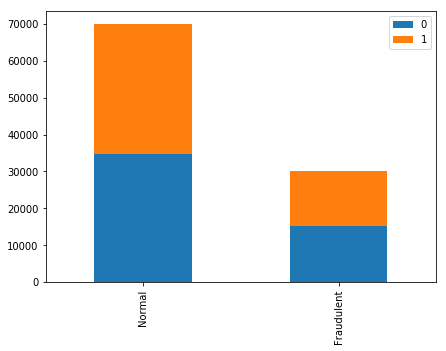

In [105]:
feature_relationship('IsValidAddress')

1    50154
0    49846
Name: IsDeliveryRejected, dtype: int64
--------------------------------------
IsDeliveryRejected  Fraud
0                   0        34838
                    1        15008
1                   0        35162
                    1        14992
Name: Fraud, dtype: int64


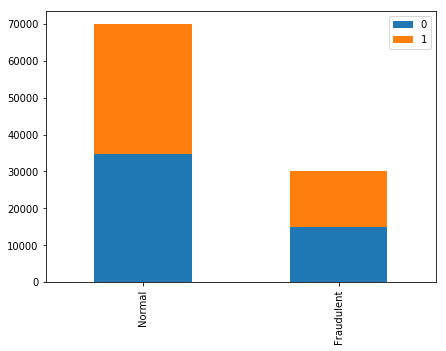

In [106]:
feature_relationship('IsDeliveryRejected') 

### Correlating Features

In [107]:
plt.figure(figsize=(15,6))
plt.show()

<Figure size 1080x432 with 0 Axes>

### Histogram for each parameter

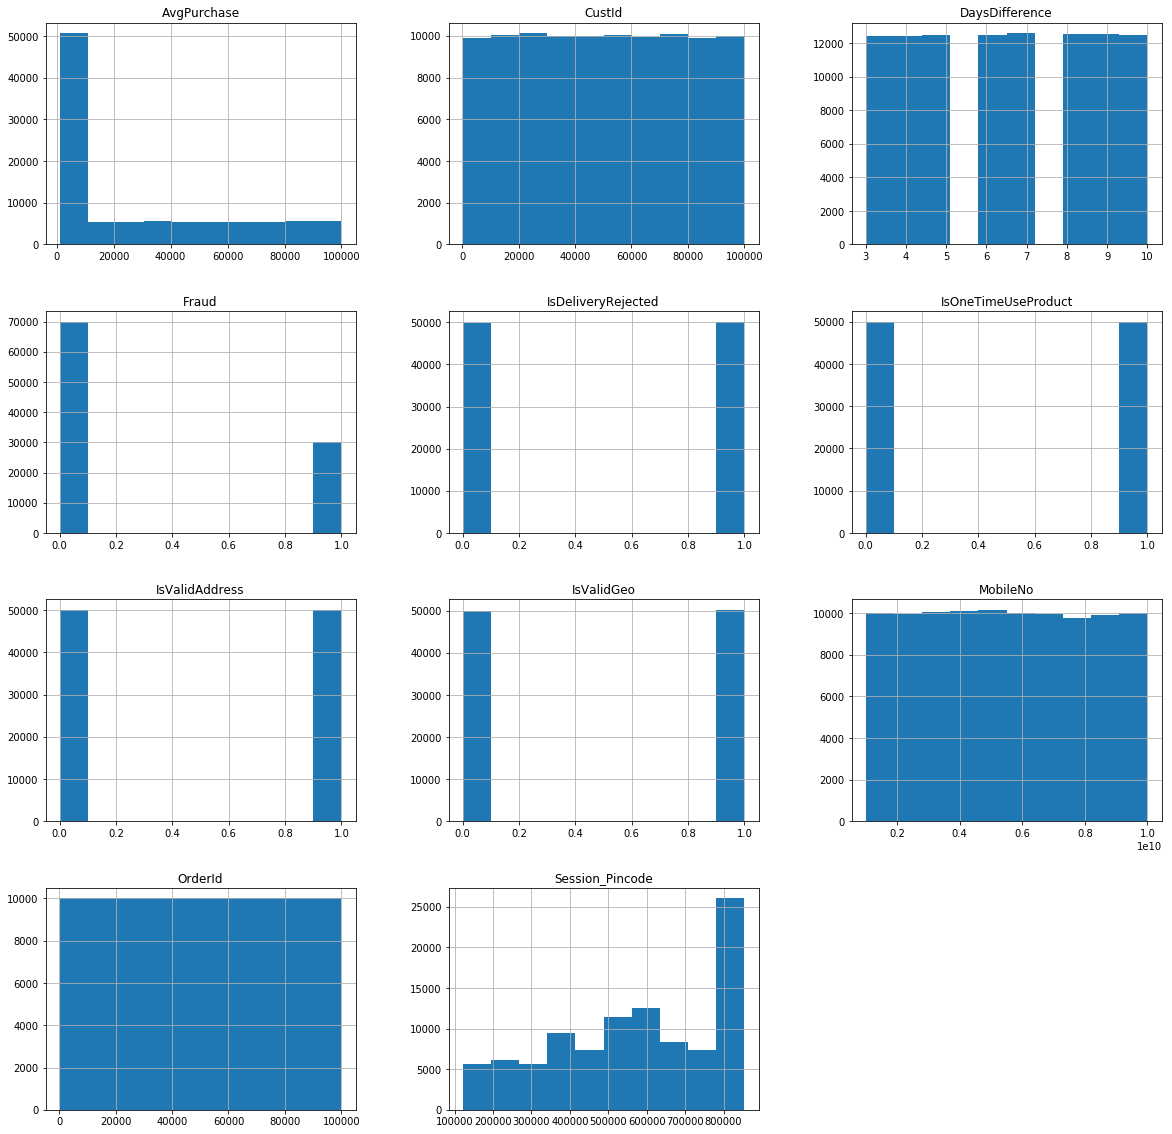

In [108]:
df.hist(figsize=(20,20))
plt.show()

In [109]:
from sklearn.preprocessing import LabelEncoder
categorical = ['IsValidAddress','IsDeliveryRejected','IsOneTimeUseProduct','IsValidGeo','City']

label_encoder = LabelEncoder()
for col in categorical:
    df[col] = label_encoder.fit_transform(df[col].astype(str))

df=df.iloc[:df.shape[0]]

In [110]:
df['domain'] = df['EmailId'].str.split('@').str[1]
df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,CustId,OrderId,EmailId,MobileNo,MacAddress,Session_Pincode,AvgPurchase,City,OrderDate,DeliveryDate,DaysDifference,ReplacementDate,IsDeliveryRejected,IsOneTimeUseProduct,IsValidAddress,IsValidGeo,Fraud,domain
0,47019,41601,aQGHuxe@yahoo.com,1867946110,1DBA453FE543,276001,99522,529,25-01-2019,28-01-2019,3,01-02-2019,1,0,1,1,0,yahoo.com
1,20242,30352,sej94kG@hotmail.com,9272875375,65D1F362F744,505468,3491,637,06-02-2019,10-02-2019,4,17-02-2019,0,1,0,1,0,hotmail.com
2,79619,12328,HTVm_XUBz@gmail.com,3251871005,DF6DBF6C2359,586209,5262,222,12-01-2019,22-01-2019,10,01-02-2019,1,0,1,0,1,gmail.com
3,79619,80750,HTVm_XUBz@gmail.com,3251871005,DF6DBF6C2359,791102,5262,222,19-01-2019,26-01-2019,7,31-01-2019,0,1,0,0,0,gmail.com
4,80669,19203,dPiRkMo3i@gmail.com,3152175434,495560A5F52B,250001,4957,926,27-03-2019,03-04-2019,7,06-04-2019,0,0,1,1,0,gmail.com


In [111]:
df.domain.unique()

array(['yahoo.com', 'hotmail.com', 'gmail.com', 'aol.com', 'mail.com'],
      dtype=object)

hotmail.com    20174
mail.com       20117
yahoo.com      20054
gmail.com      19860
aol.com        19795
Name: domain, dtype: int64
--------------------------------------
domain       Fraud
aol.com      0        13852
             1         5943
gmail.com    0        13850
             1         6010
hotmail.com  0        14097
             1         6077
mail.com     0        14121
             1         5996
yahoo.com    0        14080
             1         5974
Name: Fraud, dtype: int64


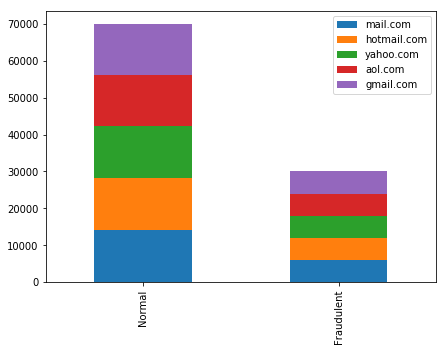

In [112]:
feature_relationship('domain')

In [113]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
features = pd.DataFrame(df)
labels = pd.DataFrame(features['Fraud'])
features = features.drop(['Fraud','EmailId','MacAddress'], axis=1)
features = features.apply(LabelEncoder().fit_transform)
features.head()

,CustId,OrderId,MobileNo,Session_Pincode,AvgPurchase,City,OrderDate,DeliveryDate,DaysDifference,ReplacementDate,IsDeliveryRejected,IsOneTimeUseProduct,IsValidAddress,IsValidGeo,domain
0,29653,41501,6101,134,35167,529,74,90,0,0,1,0,1,1,4
1,12665,30252,58249,383,2422,637,18,34,1,59,0,1,0,1,2
2,50439,12228,15784,522,4133,222,35,72,7,0,1,0,1,0,1
3,50439,80650,15784,787,4133,222,56,84,4,104,0,1,0,0,1
4,51092,19103,15101,112,3836,926,82,8,4,17,0,0,1,1,1


In [114]:
labels.head()

,Fraud
0,0
1,0
2,1
3,0
4,0


In [115]:
# Scaling the Train and Test feature set 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


#### No Need for label encoder on label as it has oly 1 and 0 value

In [116]:
"""from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
encoder.fit(labels)
labels_enc = encoder.transform(labels)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-116-2b16d9724cd4>, line 4)

In [117]:
features

array([[-0.10815542, -0.29439668, -1.39547292, ...,  1.00020002,
         0.99676523,  1.41096813],
       [-1.03662458, -0.68407347,  1.45845407, ..., -0.99980002,
         0.99676523, -0.00548877],
       [ 1.0278912 , -1.30844314, -0.86554703, ...,  1.00020002,
        -1.00324527, -0.71371722],
       ...,
       [-0.57331913, -1.56336638,  0.92234399, ...,  1.00020002,
         0.99676523, -1.42194567],
       [-0.40591266,  0.74410635,  0.19873766, ..., -0.99980002,
         0.99676523, -1.42194567],
       [ 1.35947952,  0.56560119, -0.74793774, ...,  1.00020002,
        -1.00324527, -0.00548877]])

In [118]:
labels

,Fraud
0,0
1,0
2,1
3,0
4,0
5,1
6,0
7,1
8,0
9,1


In [188]:
from sklearn.model_selection import train_test_split
train, test, labels_train, labels_test = train_test_split(features, labels, test_size=0.60, random_state = 42)

In [189]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train, labels_train, test_size=0.20, random_state = 42)

In [190]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((32000, 15), (8000, 15), (32000, 1), (8000, 1))

In [191]:
parameter_candidates = [
  {'C': [1, 10], 'kernel': ['linear']},
  {'C': [1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
]

In [192]:
# Create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates, n_jobs=-1)

# Train the classifier on data1's feature and target data
clf.fit(X_train, y_train)   

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'C': [1, 10], 'kernel': ['linear']}, {'C': [1, 10], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [193]:
# View the accuracy score
print('Best score for data1:', clf.best_score_)

Best score for data1: 0.6999375


In [194]:
# Apply the classifier trained using data1 to data2, and view the accuracy score
clf.score(X_val, y_val) 

0.702375

In [195]:
clf.best_params_

{'C': 1, 'kernel': 'linear'}

In [196]:
# View the best parameters for the model found using grid search
print('Best C:',clf.best_estimator_.C) 
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)

Best C: 1
Best Kernel: linear
Best Gamma: auto_deprecated


In [203]:
clf_svc = SVC(C=1, kernel='linear', gamma='auto').fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [204]:
y_pred = clf_svc.predict(X_val)

In [205]:
from sklearn import metrics
# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_pred,y_val))

Accuracy: 0.702375


In [206]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_pred,y_val,average=None))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_pred,y_val,average=None))


print("F1 score:",metrics.f1_score(y_pred,y_val,average=None))

#f1_scores[clf_name] = f1_score(y_pred, y_valid)

Precision: [1. 0.]
Recall: [0.702375 0.      ]
F1 score: [0.82517072 0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Standardise the training and testing data and oversampling using SMOTE

In [207]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=0)
x_train_std_os,y_train_os = sm.fit_sample(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [208]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0).fit(x_train_std_os,y_train_os)
lr_pred = lr.predict(X_val)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [209]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0).fit(x_train_std_os,y_train_os)
tree_pred = tree.predict(X_val)

In [210]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0).fit(x_train_std_os,y_train_os)
rf_pred = rf.predict(X_val)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [211]:
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier().fit(x_train_std_os,y_train_os)
knn_pred = knn.predict(X_val)

In [212]:
# SVC : Linear kernel
from sklearn.svm import SVC
sv_lin = SVC(kernel='linear',random_state=0,probability=True).fit(x_train_std_os,y_train_os)
sv_lin_pred = sv_lin.predict(X_val)

In [213]:
# SVC : RBF kernel
from sklearn.svm import SVC
sv_rbf = SVC(kernel='rbf',random_state=0,probability=True).fit(x_train_std_os,y_train_os)
sv_rbf_pred = sv_rbf.predict(X_val)

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [226]:
from sklearn.metrics import precision_recall_curve,average_precision_score,auc,roc_auc_score

models = ['LR','Decision Tree','Random Forest','KNN','Linear kernel SVM','RBF kernel SVM']
preds = [lr_pred,tree_pred,rf_pred,knn_pred,sv_lin_pred,sv_rbf_pred]
for pred,model in zip(preds,models):
    precision,recall,thresholds = precision_recall_curve(y_val,pred)
    print ('Area under precision recall curve for %s model = '%(model),round(auc(recall,precision),3))
    print ('Area under ROC curve for %s model = '%(model),round(roc_auc_score(y_val,pred),3)) 
    print("F1 score :",metrics.f1_score(y_val,pred,average=None),'\n')

Area under precision recall curve for LR model =  0.479
Area under ROC curve for LR model =  0.509
F1 score : [0.59395695 0.38068182] 

Area under precision recall curve for Decision Tree model =  0.42
Area under ROC curve for Decision Tree model =  0.508
F1 score : [0.69357033 0.32053087] 

Area under precision recall curve for Random Forest model =  0.352
Area under ROC curve for Random Forest model =  0.502
F1 score : [0.77289495 0.19773371] 

Area under precision recall curve for KNN model =  0.483
Area under ROC curve for KNN model =  0.514
F1 score : [0.60014446 0.38579807] 

Area under precision recall curve for Linear kernel SVM model =  0.487
Area under ROC curve for Linear kernel SVM model =  0.514
F1 score : [0.59144943 0.38876755] 

Area under precision recall curve for RBF kernel SVM model =  0.472
Area under ROC curve for RBF kernel SVM model =  0.509
F1 score : [0.60875749 0.37453305] 



In [215]:
print("F1 score Linear kernel:",metrics.f1_score(sv_lin_pred,y_val,average=None))

F1 score Linear kernel: [0.59144943 0.38876755]


In [216]:
print("F1 score RBF kernel:",metrics.f1_score(y_val,sv_rbf_pred,average=None))

F1 score RBF kernel: [0.60875749 0.37453305]


In [223]:
from xgboost.sklearn import XGBClassifier 
import scipy.stats as st
xgb = XGBClassifier(learning_rate= 0.01,
                     max_depth= 15,
                     min_child_weight= 10,
                     n_estimators= 50,                     
                     subsample= 0.9)

In [224]:
xgb.fit(X_train,y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=15, min_child_weight=10, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.9)

In [225]:
xgb.score(X_train,y_train)  

0.6999375

In [221]:
xgb_pred = xgb.predict(X_val)

In [222]:
print("Precision:",metrics.precision_score(xgb_pred,y_val,average=None))

# Model Recall: what percentage of positive tuples are la

Precision: [1. 0.]
Recall: [0.702375 0.      ]
F1 score: [0.82517072 0.        ]


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [1]:
accuracy_score(y_test, y_pred)

NameError: name 'accuracy_score' is not defined

In [6]:
import json
F1Fraud = "39.0"
F1Normal = "59.0"
data = {"F1 Fraud":F1Fraud,"F1 Normal":F1Normal, "model": "SVM"}
jstr = json.dumps(data)

with open('F1.json', 'w') as outfile: 
    json.dumps(data)

In [3]:
temp1 = metrics.f1_score(y_val,pred,average=None)[1]
temp2 = metrics.f1_score(y_val,pred,average=None)[0]

# F1Fraud= temp1*100
# F1Normal= temp2*100


F1Fraud = str(round(temp1, 2)*100)
F1Normal = str(round(temp2, 2)*100)


print(F1Fraud,F1Normal,sep="\n")

NameError: name 'metrics' is not defined

In [8]:
import json

f1_fraud = 39
f1_normal = 59
data = {
    'f1_fraud': f1_fraud,
    'f1_normal': f1_normal,
    'model': 'SVM'
}


with open("data_file.json", "w") as write_file:
    json.dump(data, write_file)
    
with open("data_file.json", "r") as read_file:
    data = json.load(read_file)
    
print(data)

{'f1_fraud': 39, 'f1_normal': 59, 'model': 'SVM'}
